In [2]:
import numpy as np
import pandas as pd
from sklearn import metrics

import nbfuns
import importlib
importlib.reload(nbfuns)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import ModelCheckpoint, EarlyStopping

from experiments.models import model_purchase100
import experiments.data_utils

from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack import data_structures
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack import membership_inference_attack as mia
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack import plotting
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack import privacy_report

from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackInputData
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import SlicingSpec
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackType
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackResults

/home/enoch/g/diplomski/env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
attacks_result = AttackResults.load("./pickles/attack_results_purchase100-small.p")

Best-performing attacks over all slices
  RANDOM_FOREST (with 59 training and 59 test examples) achieved an AUC of 1.00 on slice CLASS=25
  RANDOM_FOREST (with 59 training and 59 test examples) achieved an advantage of 1.00 on slice CLASS=25

Best-performing attacks over slice: "Entire dataset"
  RANDOM_FOREST (with 24665 training and 24665 test examples) achieved an AUC of 0.95
  RANDOM_FOREST (with 24665 training and 24665 test examples) achieved an advantage of 0.80

Best-performing attacks over slice: "CLASS=0"
  RANDOM_FOREST (with 177 training and 177 test examples) achieved an AUC of 0.93
  K_NEAREST_NEIGHBORS (with 177 training and 177 test examples) achieved an advantage of 0.75

Best-performing attacks over slice: "CLASS=1"
  K_NEAREST_NEIGHBORS (with 101 training and 101 test examples) achieved an AUC of 0.94
  THRESHOLD_ATTACK (with 101 training and 101 test examples) achieved an advantage of 0.81

Best-performing attacks over slice: "CLASS=2"
  RANDOM_FOREST (with 574 trai

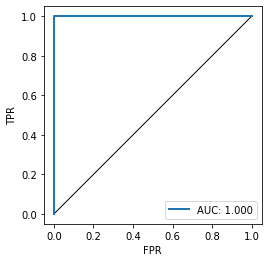

In [4]:
# Plot the ROC curve of the best classifier
fig = plotting.plot_roc_curve(
    attacks_result.get_result_with_max_auc().roc_curve)

# Print a user-friendly summary of the attacks
print(attacks_result.summary(by_slices = True))

In [5]:
res_df = attacks_result.calculate_pd_dataframe()
print(attacks_result.summary(by_slices = False))

Best-performing attacks over all slices
  RANDOM_FOREST (with 59 training and 59 test examples) achieved an AUC of 1.00 on slice CLASS=25
  RANDOM_FOREST (with 59 training and 59 test examples) achieved an advantage of 1.00 on slice CLASS=25


slice feature slice value  train size  test size          attack type  \
5           class           0         177        177  K_NEAREST_NEIGHBORS   
8           class           1         101        101  K_NEAREST_NEIGHBORS   
11          class           2         574        574  K_NEAREST_NEIGHBORS   
14          class           3         129        129  K_NEAREST_NEIGHBORS   
17          class           4         306        306  K_NEAREST_NEIGHBORS   
..            ...         ...         ...        ...                  ...   
290         class          95         101        101  K_NEAREST_NEIGHBORS   
293         class          96         122        122  K_NEAREST_NEIGHBORS   
296         class          97         293        293  K_NEAREST_NEIGHBORS   
299         class          98         238        238  K_NEAREST_NEIGHBORS   
302         class          99         200        200  K_NEAREST_NEIGHBORS   

     Attacker advantage       AUC  
5              0.750000  0.865152  
8              0.800000  0.940000  
11             0.679681  0.893332  
14             0.661932  0.828598  
17             0.701299  0.896104  
..                  ...       ...  
290            0.921538  0.976154  
293            0.903226  0.945699  
296            0.824324  0.938634  
299            0.798305  0.912288  
302            0.840000  0.929600  

[100 rows x 7 columns]

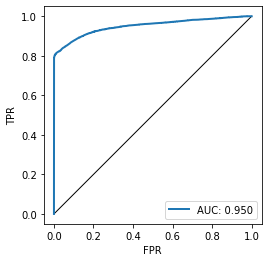

In [6]:
fig = plotting.plot_roc_curve(
    attacks_result.single_attack_results[1].roc_curve)

attack_types = [AttackType.THRESHOLD_ATTACK,
                AttackType.RANDOM_FOREST,
                AttackType.K_NEAREST_NEIGHBORS]

res_df.drop(res_df[res_df["slice feature"] == "Entire dataset"].index, inplace=True)
res_df.drop(res_df[res_df["slice feature"] == "correctly_classified"].index, inplace=True)

res_ta = res_df.loc[res_df['attack type'] == "THRESHOLD_ATTACK"]
res_rf = res_df.loc[res_df['attack type'] == "RANDOM_FOREST"]
res_knn = res_df.loc[res_df['attack type'] == "K_NEAREST_NEIGHBORS"]

res_knn

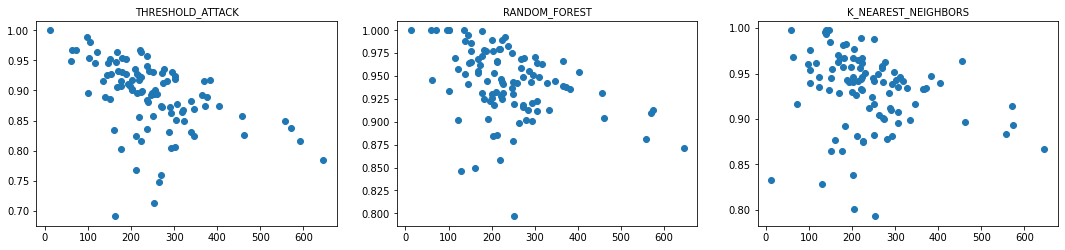

In [7]:
import matplotlib.pyplot as plt

fsize = (nbfuns._DEFAULT_FIGSIZE[0] * 3, nbfuns._DEFAULT_FIGSIZE[1])
fig, ax = plt.subplots(1, 3, figsize=fsize)
for i, atk_type in enumerate(attack_types):
    res = res_df.loc[res_df['attack type'] == str(atk_type)]
    ax[i].scatter(res["train size"], res["AUC"])
    ax[i].set_title(str(atk_type), fontsize="medium")
    #res.plot(
    #   x="train size",
    #    y=["AUC"],
    #    kind="scatter",
    #    layout=(1,2),
    #    xlabel="Class index",
    #    title="AUC: " + str(atk_type),
    #    )
#fig.suptitle('Purchase100 Small NN: Results Per Slices', fontsize="large")
#fig.subplots_adjust(top=0.88)
plt.savefig("./img/purchase100-atk-types/purchase100-small.pdf", bbox_inches='tight')

<Figure size 439.352x271.535 with 0 Axes>

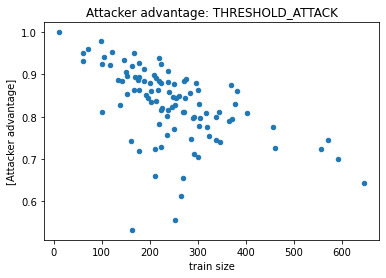

<Figure size 439.352x271.535 with 0 Axes>

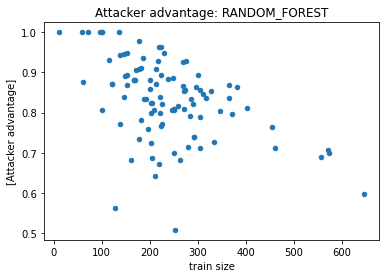

<Figure size 439.352x271.535 with 0 Axes>

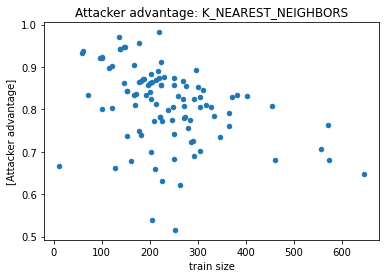

In [7]:
for atk_type in attack_types:
    res = res_df.loc[res_df['attack type'] == str(atk_type)]
    plt.figure(figsize=figsize_tex)
    res.plot(
        x="train size",
        y=["Attacker advantage"],
        kind="scatter",
        layout=(1,2),
        xlabel="Class index",
        title="Attacker advantage: " + str(atk_type),
        )

<AxesSubplot:xlabel='train size', ylabel='AUC'>

<Figure size 439.352x271.535 with 0 Axes>

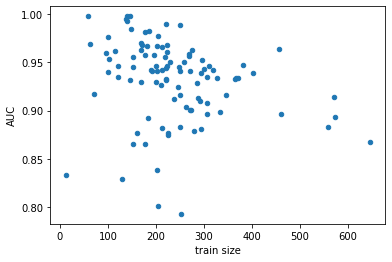

In [8]:
plt.figure(figsize=figsize_tex)
res_knn.plot(x='train size', y='AUC', kind='scatter')

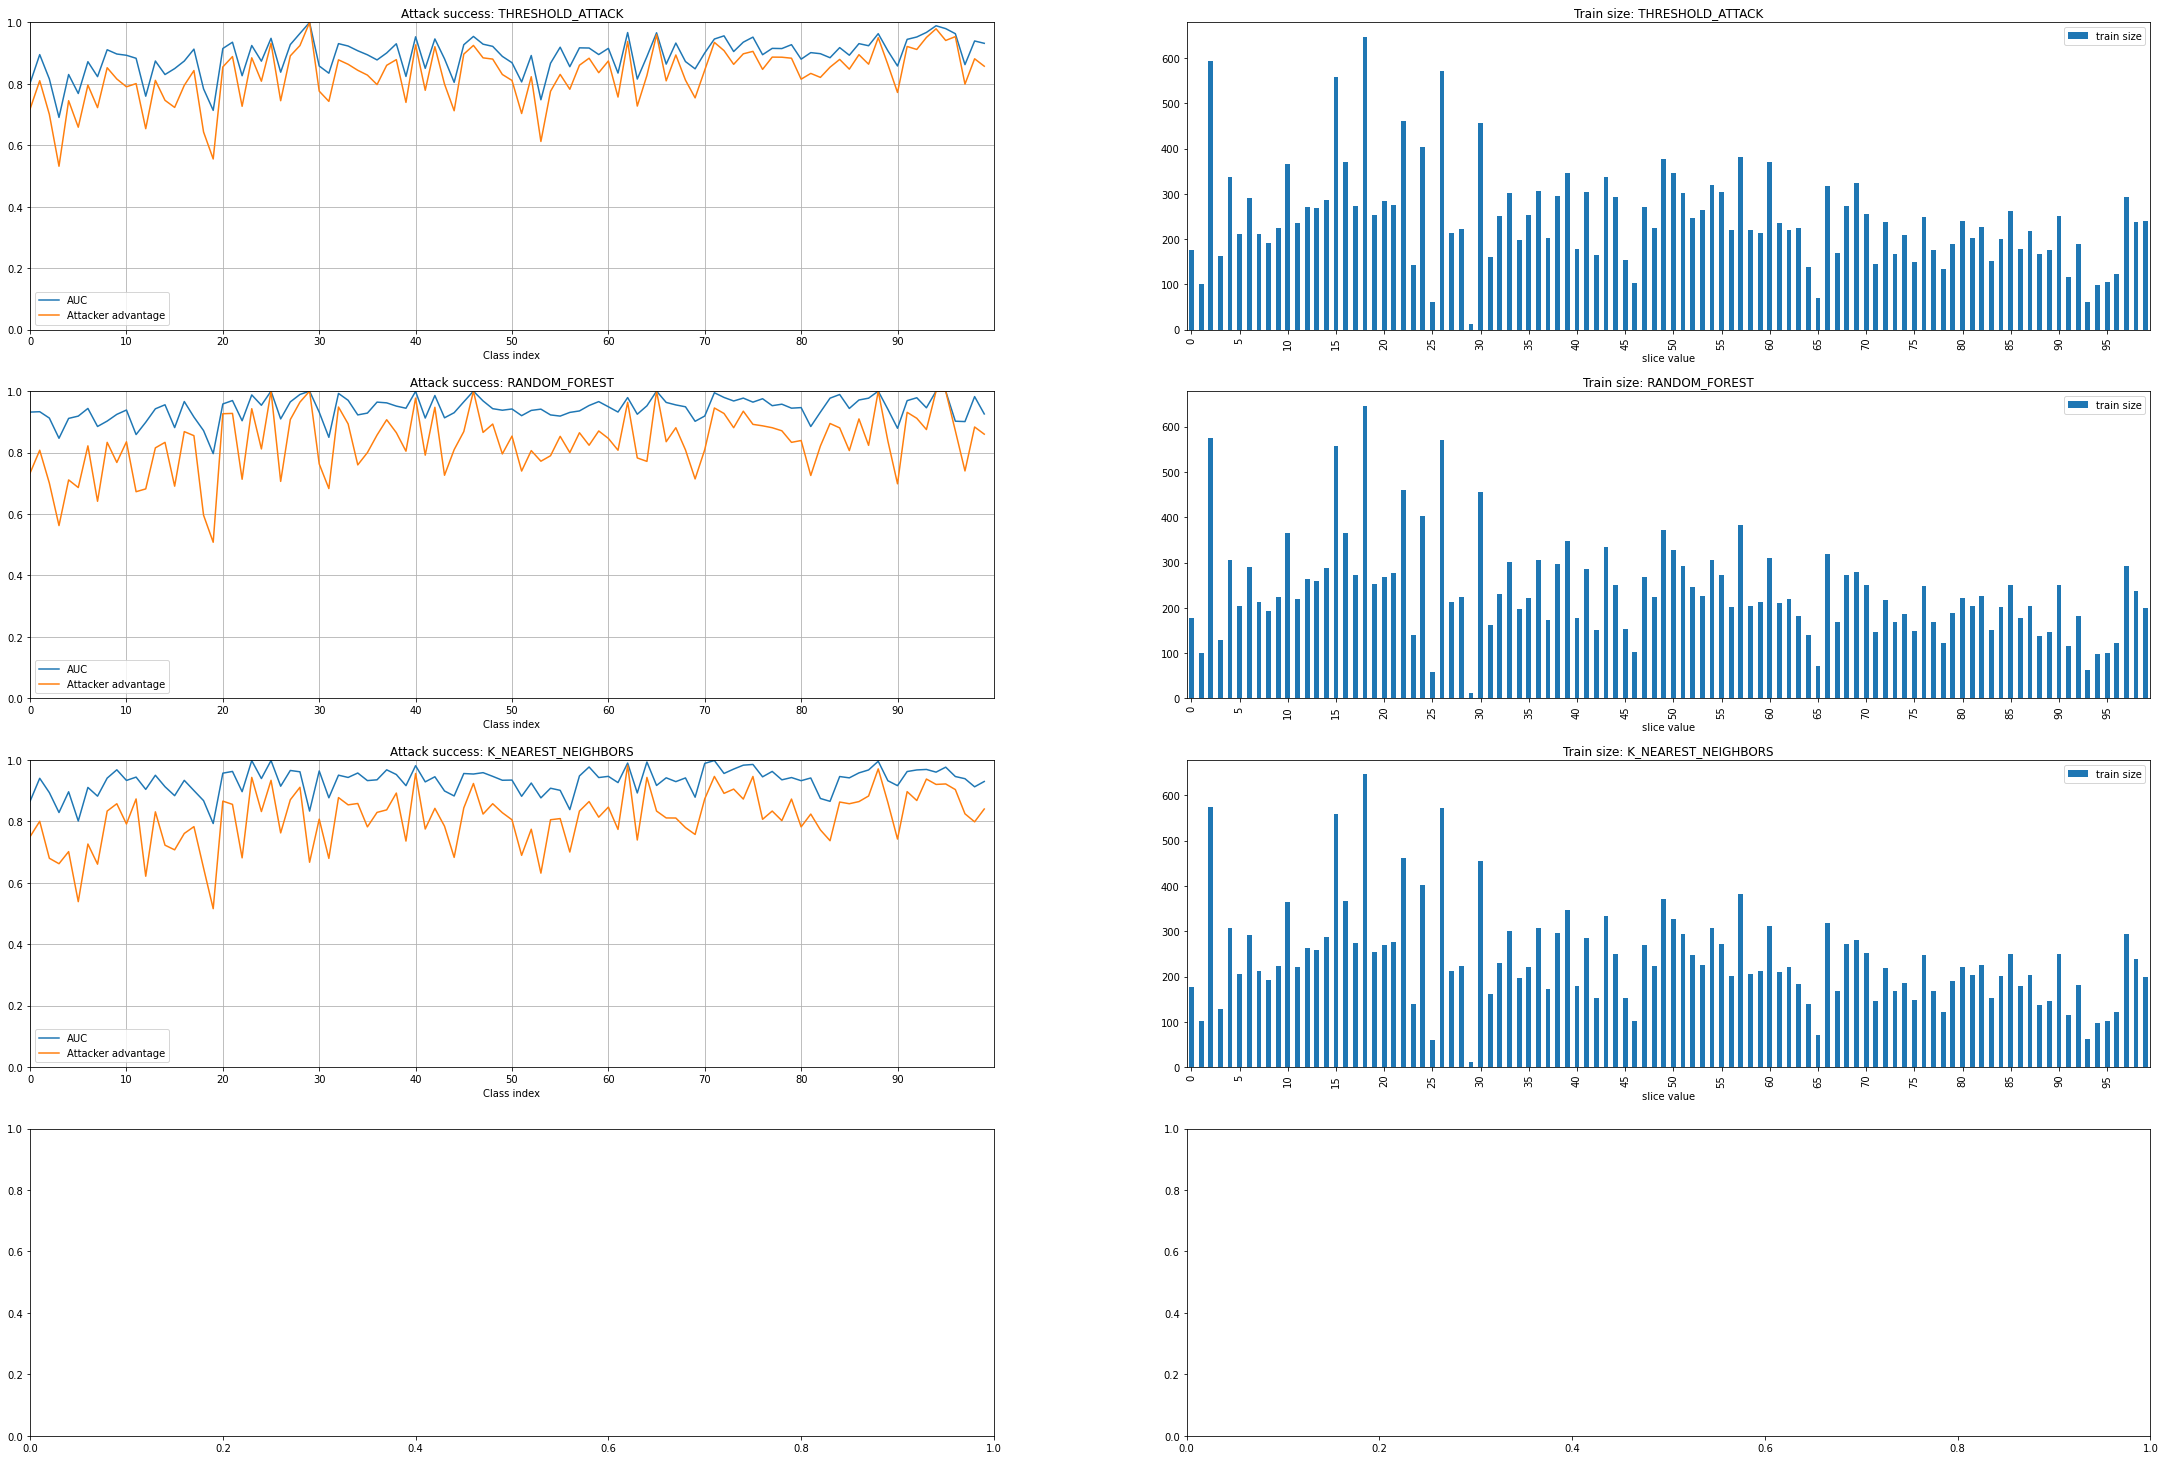

In [9]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(38,26))

for i, atk_type in enumerate(attack_types):
    res = res_df.loc[res_df['attack type'] == str(atk_type)]
    res.plot(
        x="slice value",
        y=["AUC", "Attacker advantage"],
        xlim=(0,100),
        ylim=(0,1),
        grid=True,
        xticks=range(0,100,10),
        xlabel="Class index",
        title="Attack success: " + str(atk_type),
        ax=axes[i, 0]
    )
    
    res.plot(
        x="slice value",
        y=["train size"],
        kind="bar",
        xlim=(0,100),
        #grid=True,
        xticks=range(0,100,5),
        #xlabel="Class index",
        title="Train size: " + str(atk_type),
        ax=axes[i, 1]
    )

In [10]:
(x_train, y_train), (x_test, y_test), (x_shadow, y_shadow) = experiments.data_utils.load_purchase100(shadow_size=0.75)

./datasets/dataset_purchase


In [11]:
model_weights_path="./trained_models/purchase100-small-50-epochs.hdf5"
model = model_purchase100(small=True, use_dpsgd=True)
model.summary()

try:
    model.load_weights(model_weights_path)
    print("Loaded model weights successfully from file ", model_weights_path)
except:
    print("Unable to load model")

Model: "dp_model_class"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 128)               76928     
                                                                 
 layer5 (Dense)              (None, 100)               12900     
                                                                 
Total params: 89,828
Trainable params: 89,828
Non-trainable params: 0
_________________________________________________________________


2022-06-15 22:15:04.259308: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-15 22:15:04.293613: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-15 22:15:04.294927: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-15 22:15:04.295717: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Loaded model weights successfully from file  ./trained_models/purchase100-small-50-epochs.hdf5


In [20]:
res_ta

slice feature slice value  train size  test size       attack type  \
3           class           0         177        185  THRESHOLD_ATTACK   
6           class           1         101        106  THRESHOLD_ATTACK   
9           class           2         593        574  THRESHOLD_ATTACK   
12          class           3         163        129  THRESHOLD_ATTACK   
15          class           4         338        306  THRESHOLD_ATTACK   
..            ...         ...         ...        ...               ...   
288         class          95         105        101  THRESHOLD_ATTACK   
291         class          96         122        130  THRESHOLD_ATTACK   
294         class          97         293        304  THRESHOLD_ATTACK   
297         class          98         238        279  THRESHOLD_ATTACK   
300         class          99         241        200  THRESHOLD_ATTACK   

     Attacker advantage       AUC  
3              0.718186  0.802290  
6              0.810387  0.895292  
9              0.700907  0.815924  
12             0.531983  0.690874  
15             0.745407  0.830525  
..                  ...       ...  
288            0.941348  0.979868  
291            0.953846  0.963367  
294            0.799219  0.862690  
297            0.881720  0.939686  
300            0.857552  0.932064  

[100 rows x 7 columns]

In [24]:
probs_train = model.predict(x_train)
probs_test = model.predict(x_test)
labels_train = np.argmax(y_train, axis=1)
labels_test = np.argmax(y_test, axis=1)

print(probs_train.shape)
print(probs_test.shape)
print(labels_train.shape)
print(labels_test.shape)

membership_probability_results = nbfuns.calculate_membership_probabilities(probs_train, probs_test, labels_train, labels_test)
threshold_list = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.55]
threshold_one = [0.5]
print(membership_probability_results.summary(threshold_list=threshold_list))

(24665, 100)
(24666, 100)
(24665,)
(24666,)

Membership probability analysis over slice: "Entire dataset"
  with 0.5000 as the threshold on membership probability, the precision-recall pair is (0.5062, 0.3289)
  thresholding on membership probability achieved an AUC of 0.51
  thresholding on membership probability achieved an advantage of 0.01

Membership probability analysis over slice: "CLASS=0"
  with 0.7000 as the threshold on membership probability, the precision-recall pair is (0.7029, 0.0806)
  with 0.6000 as the threshold on membership probability, the precision-recall pair is (0.6416, 0.3763)
  with 0.5000 as the threshold on membership probability, the precision-recall pair is (0.6416, 0.3763)
  with 0.5500 as the threshold on membership probability, the precision-recall pair is (0.6416, 0.3763)
  thresholding on membership probability achieved an AUC of 0.62
  thresholding on membership probability achieved an advantage of 0.17

Membership probability analysis over slice: "C

In [26]:
#for member_probas in membership_probability_results.membership_prob_results:
#    results = member_probas.collect_results([0.5], return_roc_results=True)
#    print(results)

n_classes = 1
sorted_results = res_ta.sort_values(by="AUC")
least_vulnerable = sorted_results[:n_classes]
most_vulnerable = sorted_results[len(sorted_results) - n_classes:]
least_vulnerable

print(y_train.shape)

(24665, 100)


In [27]:
def extract_inputs_using_dataframe_to_empty_ndarray(x_train, y_train, df):
    ys = np.array([], dtype=np.int64).reshape(0,100)
    xs = np.array([], dtype=np.int64).reshape(0,600)
    
    for c in df["slice value"]:
        indices = np.where(np.argmax(y_train, axis=1) == int(c))
        xs_new = x_train[indices]
        ys_new = y_train[indices]
        xs = np.vstack([xs, xs_new])
        ys = np.vstack([ys, ys_new])

    return xs, ys

In [28]:
xs_lowest, ys_lowest = extract_inputs_using_dataframe_to_empty_ndarray(x_train, y_train, least_vulnerable)
xs_highest, ys_highest = extract_inputs_using_dataframe_to_empty_ndarray(x_train, y_train, most_vulnerable)
xs_final = np.vstack([xs_lowest, xs_highest])
ys_final = np.vstack([ys_lowest, ys_highest])
ys_final = np.argmax(ys_final, axis=1)

xs_lowest_test, ys_lowest_test = extract_inputs_using_dataframe_to_empty_ndarray(x_test, y_test, least_vulnerable)
xs_highest_test, ys_highest_test = extract_inputs_using_dataframe_to_empty_ndarray(x_test, y_test, most_vulnerable)
xs_final_test = np.vstack([xs_lowest_test, xs_highest_test])
ys_final_test = np.vstack([ys_lowest_test, ys_highest_test])
ys_final_test = np.argmax(ys_final_test, axis=1)

ys_lowest = np.argmax(ys_lowest, axis=1)
ys_lowest_test = np.argmax(ys_lowest_test, axis=1)

ys_highest = np.argmax(ys_highest, axis=1)
ys_highest_test = np.argmax(ys_highest_test, axis=1)

#print(ys_highest)

Samples with highest membership risk in class 3
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 163 samples in 0.000s...
[t-SNE] Computed neighbors for 163 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 163 / 163
[t-SNE] Mean sigma: 7.124929


/home/enoch/g/diplomski/env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/enoch/g/diplomski/env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 114.741905
[t-SNE] KL divergence after 1000 iterations: 1.247824
t-SNE done! Time elapsed: 0.632641077041626 seconds


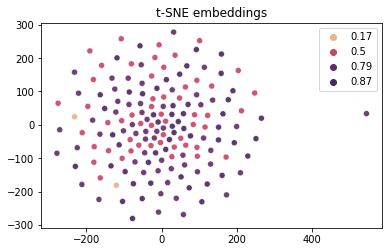

Samples with highest membership risk in class 3


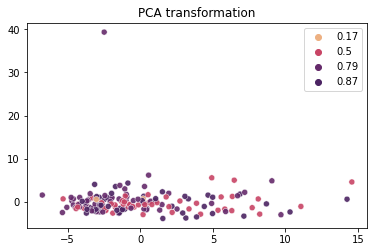

In [17]:
importlib.reload(nbfuns)

nbfuns.plot_class_membership_probabilities_with_luminance(
    model.predict(xs_lowest),
    model.predict(xs_lowest_test),
    ys_lowest,
    ys_lowest_test,
    xs_lowest,
    ys_lowest,
    use_tsne=True,
    luminance_colormap="flare"
)

nbfuns.plot_class_membership_probabilities_with_luminance(
    model.predict(xs_lowest),
    model.predict(xs_lowest_test),
    ys_lowest,
    ys_lowest_test,
    xs_lowest,
    ys_lowest,
    use_tsne=False,
    luminance_colormap="flare"
)

Samples with highest membership risk in class 29


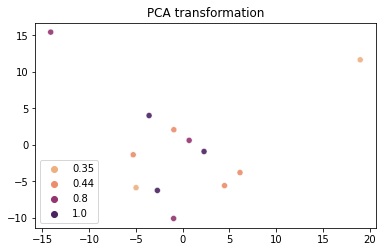

In [29]:
importlib.reload(nbfuns)

nbfuns.plot_class_membership_probabilities_with_luminance(
    model.predict(xs_highest),
    model.predict(xs_highest_test),
    ys_highest,
    ys_highest_test,
    xs_highest,
    ys_highest,
    use_tsne=False,
    luminance_colormap="flare"
)

Samples with highest membership risk in class 3


/home/enoch/g/diplomski/env/lib/python3.8/site-packages/seaborn/_core.py:882: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  val in data


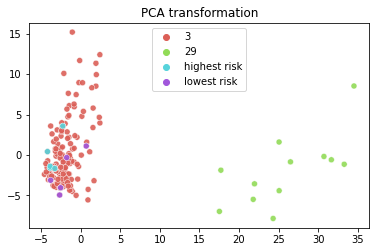

Samples with highest membership risk in class 29


/home/enoch/g/diplomski/env/lib/python3.8/site-packages/seaborn/_core.py:882: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  val in data


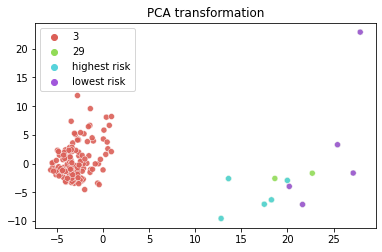

In [30]:
nbfuns.plot_membership_probabilities(
    model.predict(xs_final),
    model.predict(xs_final_test),
    ys_final,
    ys_final_test,
    xs_final,
    ys_final,
    num_samples=5,
    use_tsne=False
)

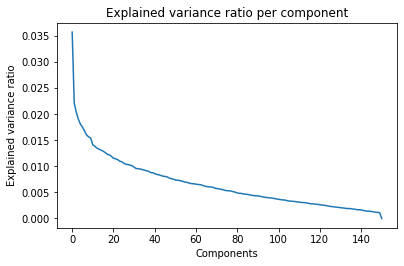

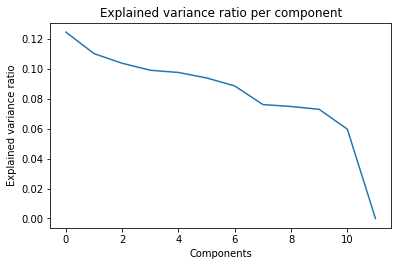

In [31]:
importlib.reload(nbfuns)

pca_lowest, res_lowest = nbfuns.plot_explained_variance_per_component(xs_lowest)
pca_highest, res_highest = nbfuns.plot_explained_variance_per_component(xs_highest)

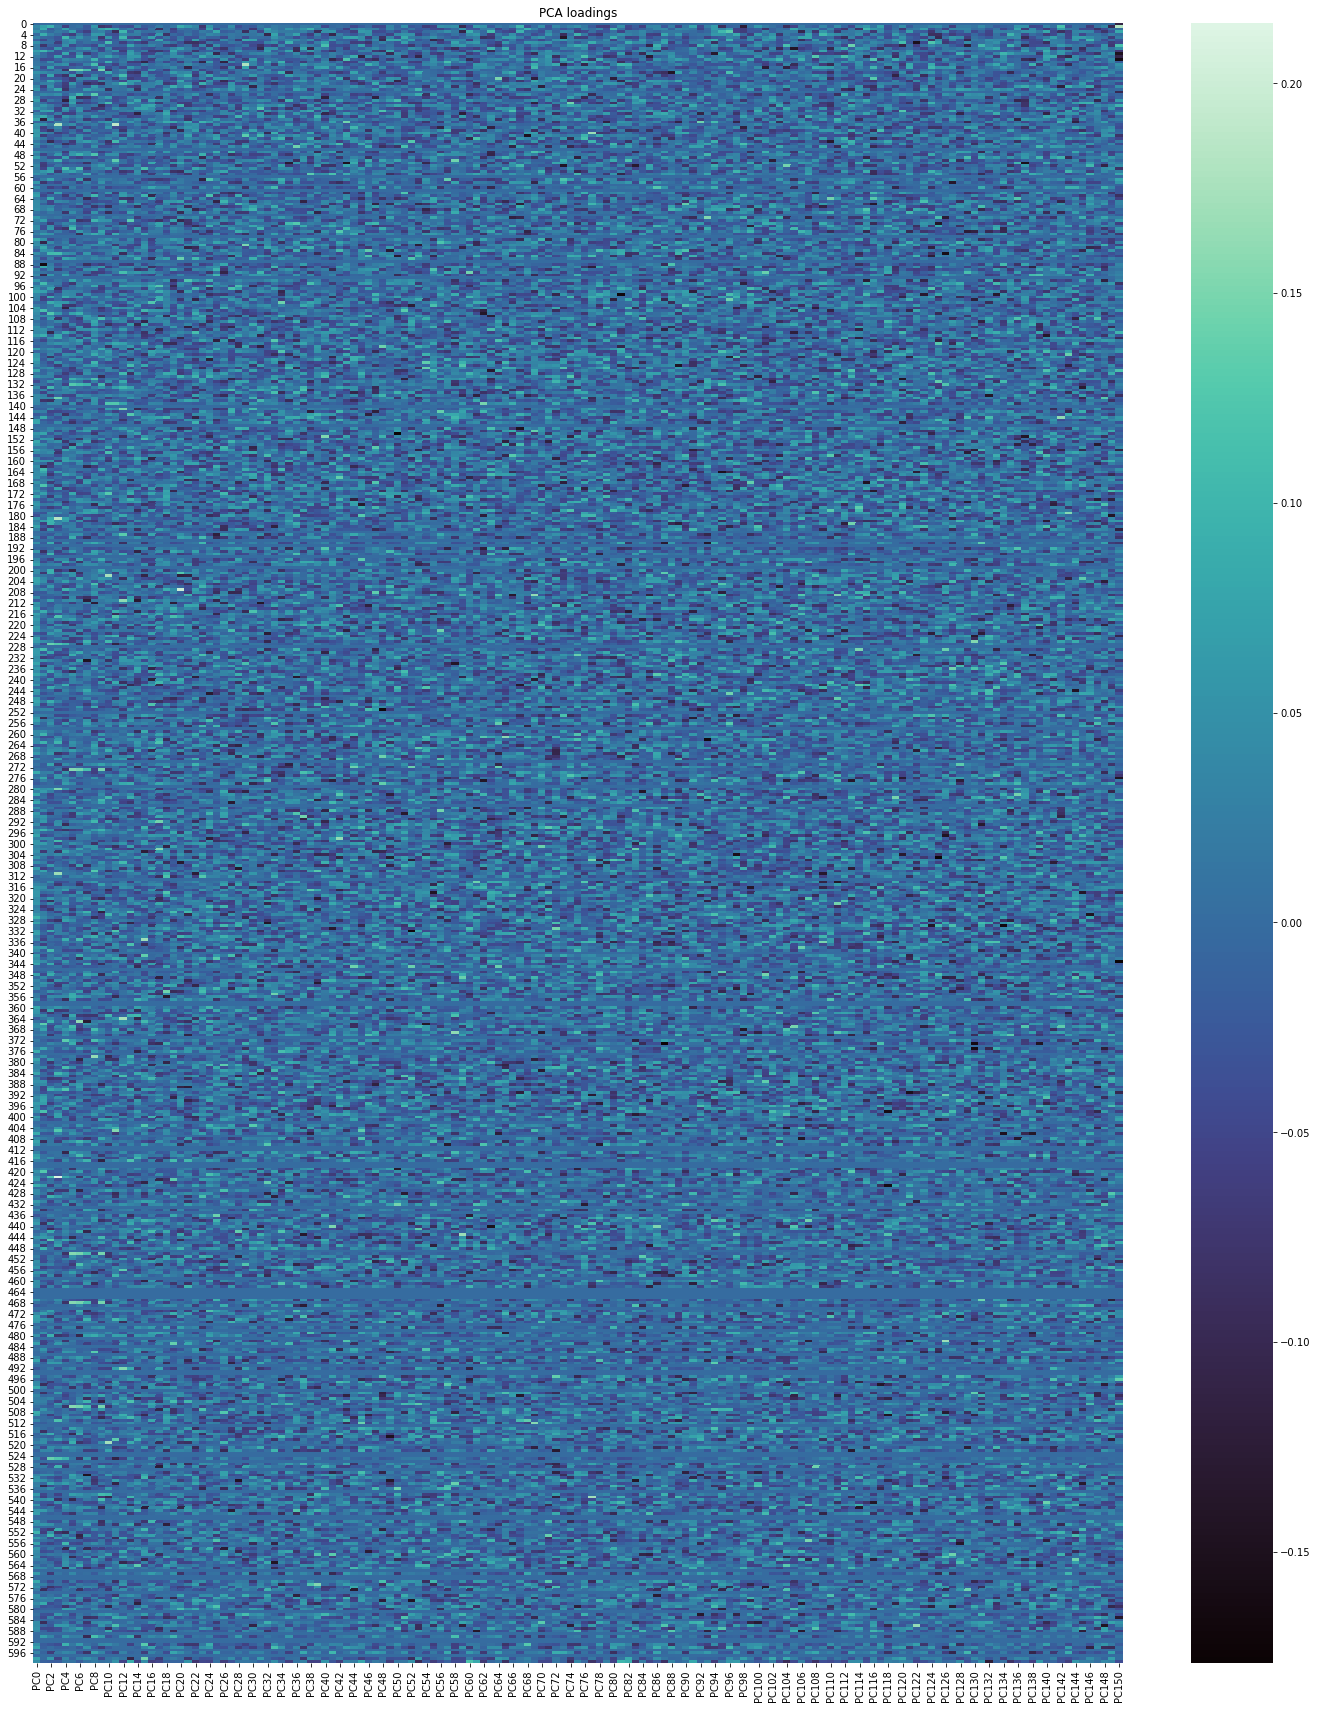

PC0           PC1           PC2           PC3           PC4  \
0   -3.380260e-17  4.479002e-18 -3.390584e-18  1.787599e-17  4.600603e-18   
1    3.589794e-02  6.672270e-02  9.313238e-02  2.124639e-02 -5.967734e-02   
2    2.573986e-02  8.203768e-02 -2.334938e-02  8.557936e-03  6.809878e-02   
3    4.976186e-02  1.553714e-02 -4.489643e-03  1.802356e-02  5.726086e-03   
4    3.283368e-04  8.927751e-02  2.371127e-02  2.667720e-03 -4.199016e-02   
..            ...           ...           ...           ...           ...   
595 -0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
596  3.418439e-02 -9.031188e-03 -6.421069e-02  1.670658e-02  3.841976e-02   
597 -0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
598  7.487612e-02 -1.811435e-03  6.297751e-02 -5.585591e-02  3.427342e-02   
599  4.427027e-02 -1.582249e-02 -1.816540e-02 -1.979460e-02  1.263567e-02   

              PC5           PC6           PC7           PC8           PC9  \
0    1.899944e-17 -3.473789e-17  2.562081e-18 -4.376881e-18 -5.025928e-17   
1    5.956467e-04  9.216053e-03 -2.694779e-02  5.665833e-02 -7.923001e-02   
2    4.046894e-03 -7.057998e-03 -2.481125e-02  2.995873e-02  7.378511e-02   
3    6.918205e-02 -2.845634e-02 -5.798020e-02  2.362513e-02  3.012152e-02   
4   -6.261069e-02  2.262146e-02 -2.158927e-02  6.268523e-02  5.735368e-02   
..            ...           ...           ...           ...           ...   
595 -0.000000e+00 -0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
596  2.943846e-02 -3.573450e-02 -8.114401e-02  7.744433e-02  3.537884e-02   
597 -0.000000e+00 -0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
598 -1.076967e-02  2.734277e-02  4.950406e-02  2.721949e-02 -4.603476e-02   
599  7.767378e-03 -1.815229e-02  7.976396e-03  1.927071e-02  2.450959e-03   

     ...         PC141         PC142         PC143         PC144  \
0    ... -9.392545e-17  4.127076e-17 -7.923616e-17 -1.409732e-17   
1    ...  4.669413e-03  1.166070e-01 -3.239890e-02  7.063714e-03   
2    ... -3.188408e-02  6.760285e-02  1.640120e-02  1.039340e-02   
3    ... -4.850245e-02 -8.757065e-02 -5.837240e-02  3.235049e-02   
4    ... -4.459486e-02  2.389682e-02 -5.129722e-02  2.624998e-02   
..   ...           ...           ...           ...           ...   
595  ... -0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
596  ... -7.000495e-02 -2.124400e-04  8.986021e-02 -3.023389e-02   
597  ... -0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
598  ...  2.808996e-02 -3.574858e-02 -4.121891e-02 -1.667995e-02   
599  ... -6.801214e-03 -3.538133e-02 -6.225171e-02  5.672624e-02   

            PC145         PC146         PC147         PC148         PC149  \
0    5.883641e-18  2.533603e-17  6.550329e-17  3.613017e-18 -9.845831e-17   
1    7.873814e-04 -6.494094e-02  1.060187e-02  3.998688e-02 -9.895517e-02   
2   -4.701013e-02 -4.635567e-02 -8.215583e-02 -4.315913e-02  5.628656e-03   
3    4.279637e-02  3.651112e-02 -3.373418e-02 -7.865208e-02 -2.673653e-02   
4   -4.686389e-02  4.860163e-03  1.268387e-02 -1.226086e-02  2.414006e-02   
..            ...           ...           ...           ...           ...   
595 -0.000000e+00 -0.000000e+00  0.000000e+00 -0.000000e+00  0.000000e+00   
596 -5.356408e-02 -2.098158e-02 -3.786163e-02 -2.269428e-02  7.157291e-02   
597 -0.000000e+00 -0.000000e+00  0.000000e+00 -0.000000e+00  0.000000e+00   
598 -3.799129e-03  4.313613e-02  9.815344e-03 -8.722330e-03  6.980178e-02   
599  2.579488e-02  2.152915e-02  2.254820e-03  3.789391e-02  2.912592e-02   

        PC150  
0   -0.111751  
1    0.181950  
2    0.006048  
3    0.083450  
4    0.003571  
..        ...  
595  0.000000  
596 -0.017864  
597  0.000000  
598  0.000313  
599 -0.040957  

[600 rows x 151 columns]

In [32]:
importlib.reload(nbfuns)

coef = 4
new_figsize = (nbfuns._DEFAULT_FIGSIZE[0] * coef, nbfuns._DEFAULT_FIGSIZE[1] * 2 * coef)
df_lowest = pd.DataFrame(xs_lowest)
nbfuns.plot_pca_loadings_heatmap_from_dataframe(df_lowest, pca_lowest, figsize=new_figsize)

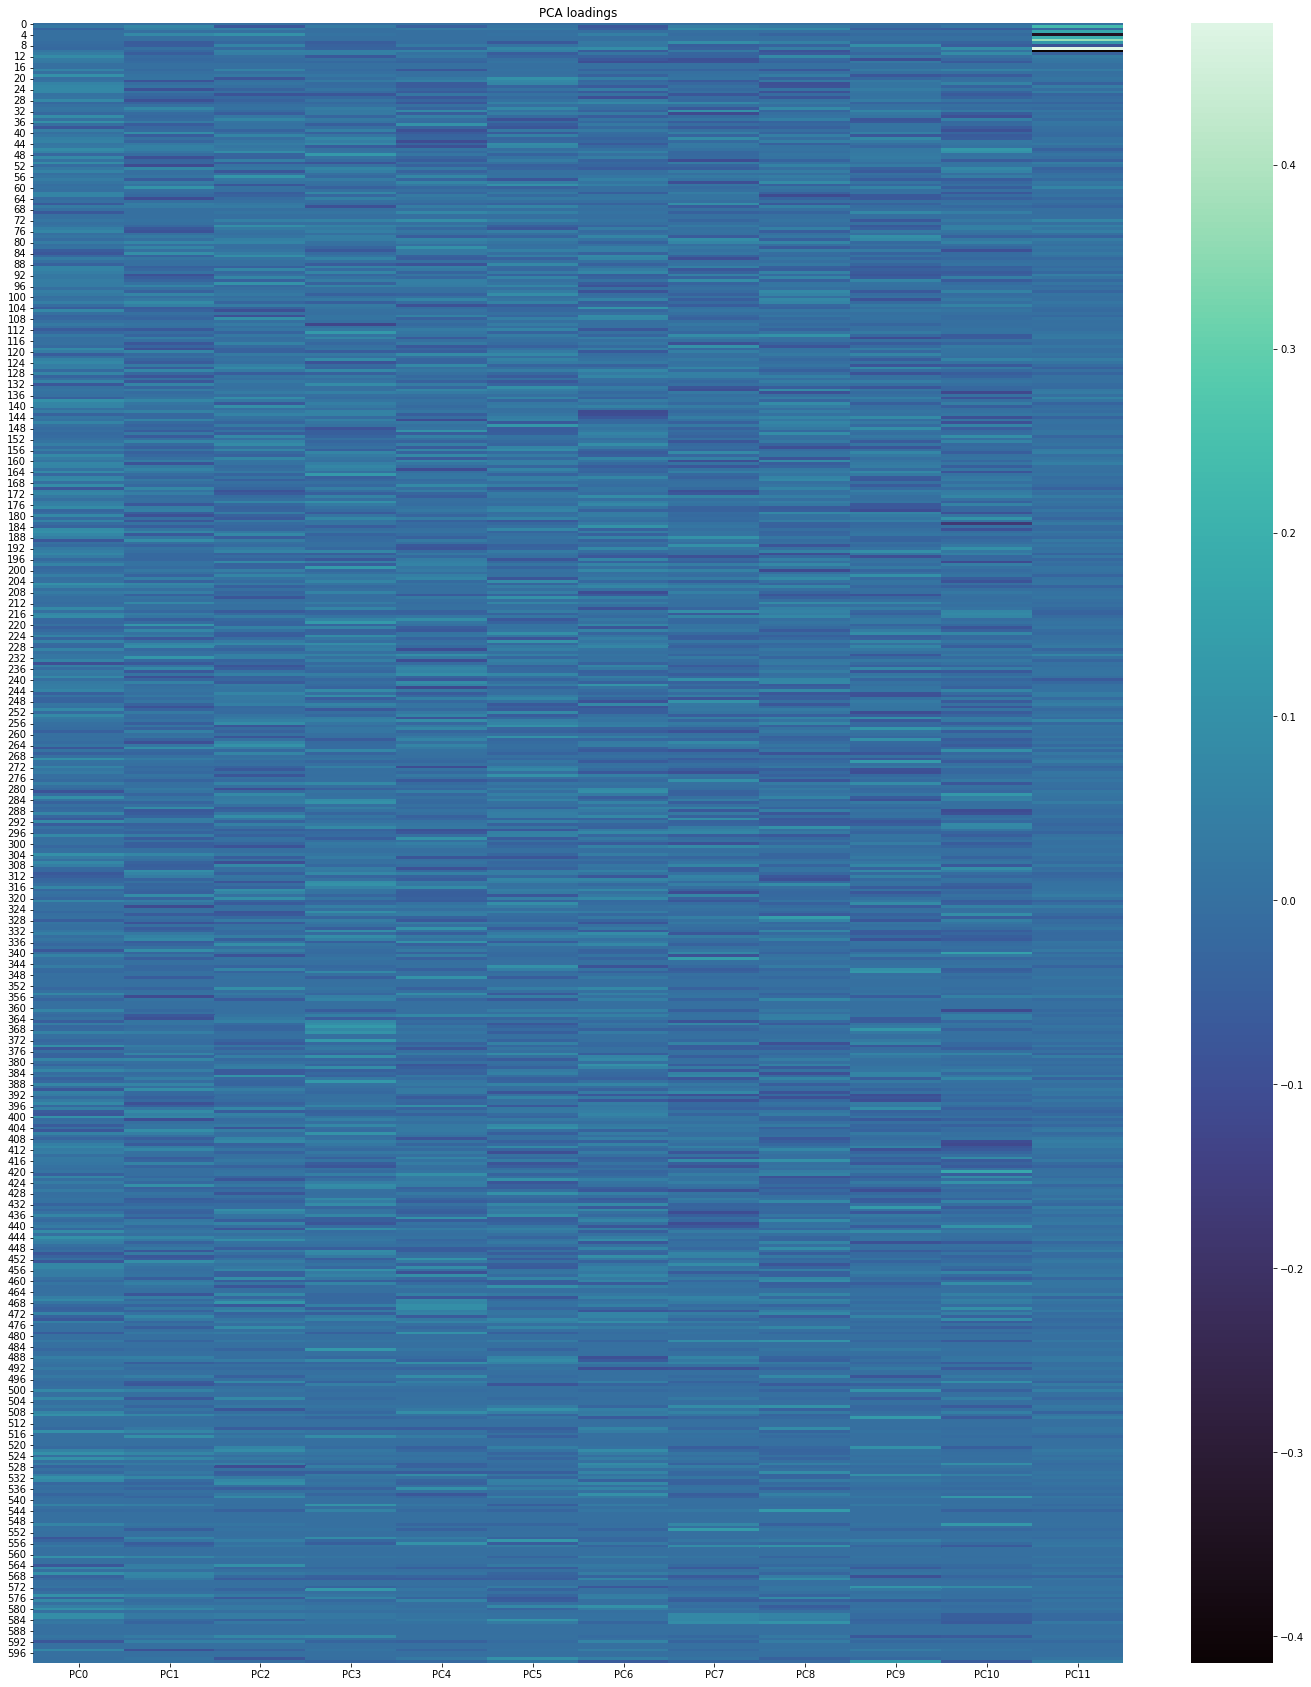

<Figure size 432x288 with 0 Axes>

In [33]:
importlib.reload(nbfuns)

df_highest = pd.DataFrame(xs_highest)
nbfuns.plot_pca_loadings_heatmap_from_dataframe(df_highest, pca_highest, figsize=new_figsize)
#plt.savefig("img/purchase100-loadings-heatmap-highest-risk.svg")
f = plt.gcf()
f.savefig("./img/purchase100-loadings-heatmap-highest-risk.svg")

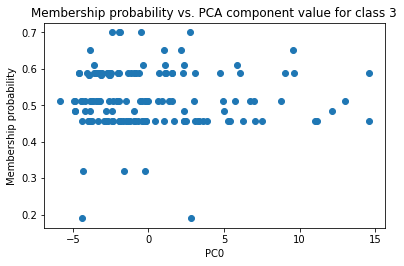

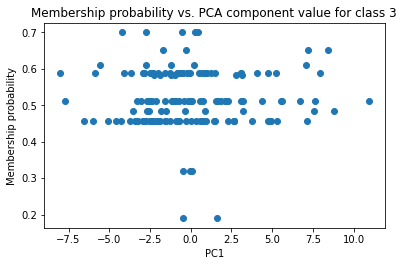

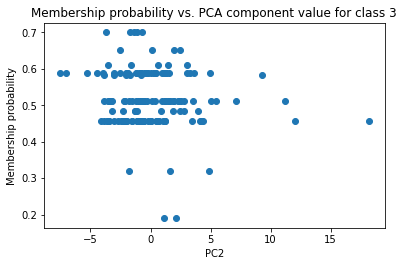

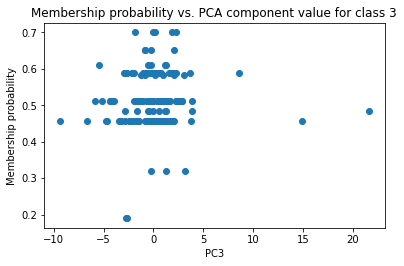

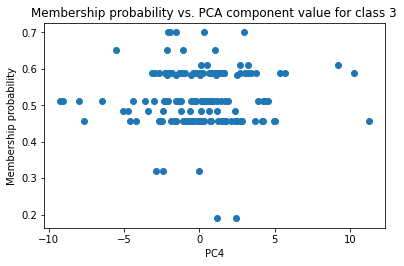

In [34]:
importlib.reload(nbfuns)

nbfuns.plot_pca_component_dependency_on_membership_risk(
    model.predict(xs_lowest),
    model.predict(xs_lowest_test),
    ys_lowest,
    ys_lowest_test,
    xs_lowest,
    ys_lowest,
    n_components=5
)

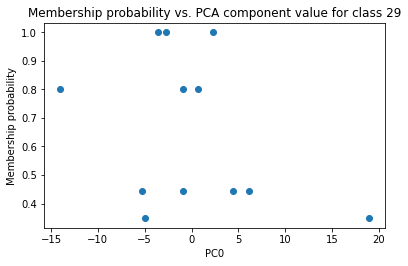

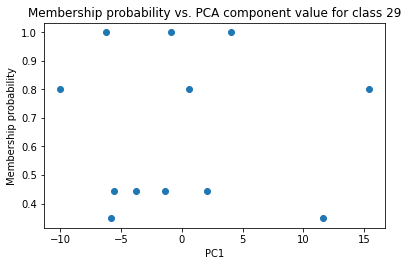

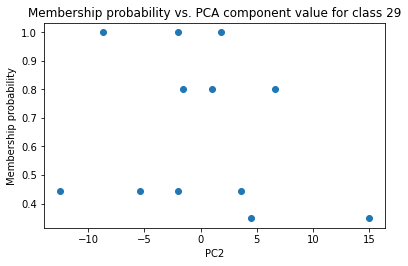

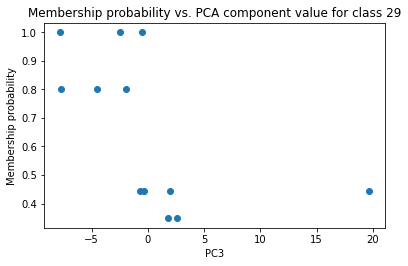

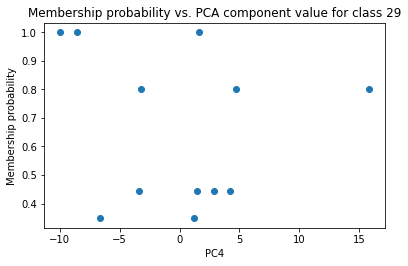

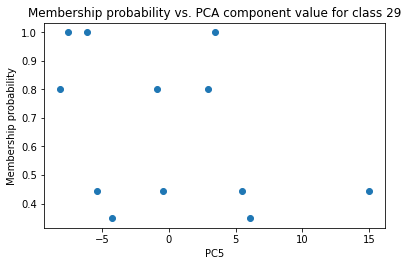

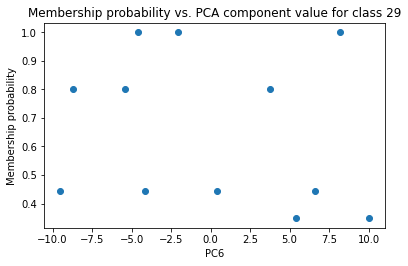

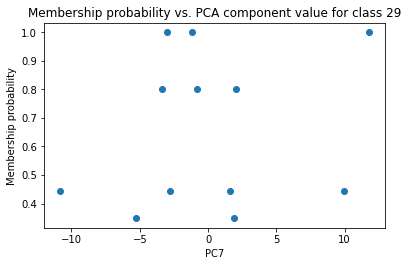

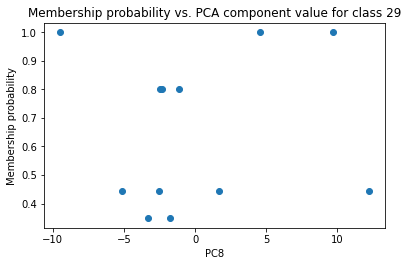

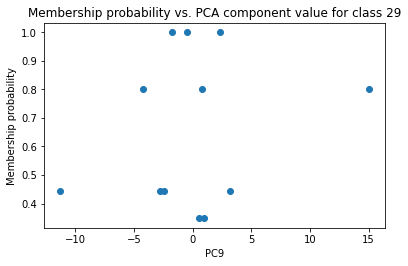

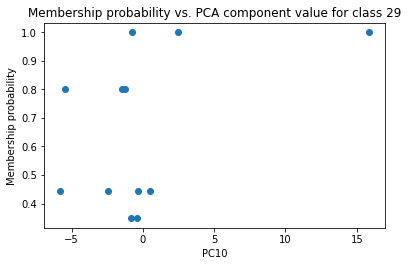

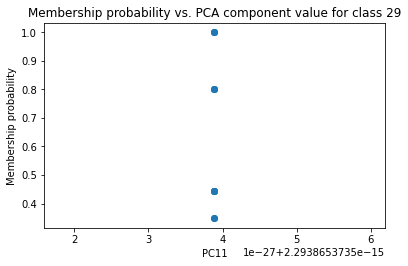

In [35]:
nbfuns.plot_pca_component_dependency_on_membership_risk(
    model.predict(xs_highest),
    model.predict(xs_highest_test),
    ys_highest,
    ys_highest_test,
    xs_highest,
    ys_highest,
)

In [36]:
df_lowest.describe()

0           1           2           3           4           5    \
count  151.0  151.000000  151.000000  151.000000  151.000000  151.000000   
mean     0.0    0.377483    0.119205    0.735099    0.105960    0.218543   
std      0.0    0.486371    0.325108    0.442749    0.308811    0.414633   
min      0.0    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.0    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.0    0.000000    0.000000    1.000000    0.000000    0.000000   
75%      0.0    1.000000    0.000000    1.000000    0.000000    0.000000   
max      0.0    1.000000    1.000000    1.000000    1.000000    1.000000   

              6           7           8           9    ...         590    591  \
count  151.000000  151.000000  151.000000  151.000000  ...  151.000000  151.0   
mean     0.039735    0.079470    0.443709    0.562914  ...    0.033113    0.0   
std      0.195986    0.271371    0.498474    0.497677  ...    0.179526    0.0   
min      0.000000    0.000000    0.000000    0.000000  ...    0.000000    0.0   
25%      0.000000    0.000000    0.000000    0.000000  ...    0.000000    0.0   
50%      0.000000    0.000000    0.000000    1.000000  ...    0.000000    0.0   
75%      0.000000    0.000000    1.000000    1.000000  ...    0.000000    0.0   
max      1.000000    1.000000    1.000000    1.000000  ...    1.000000    0.0   

         592         593         594    595         596    597         598  \
count  151.0  151.000000  151.000000  151.0  151.000000  151.0  151.000000   
mean     0.0    0.026490    0.205298    0.0    0.125828    0.0    0.059603   
std      0.0    0.161122    0.405263    0.0    0.332759    0.0    0.237537   
min      0.0    0.000000    0.000000    0.0    0.000000    0.0    0.000000   
25%      0.0    0.000000    0.000000    0.0    0.000000    0.0    0.000000   
50%      0.0    0.000000    0.000000    0.0    0.000000    0.0    0.000000   
75%      0.0    0.000000    0.000000    0.0    0.000000    0.0    0.000000   
max      0.0    1.000000    1.000000    0.0    1.000000    0.0    1.000000   

              599  
count  151.000000  
mean     0.158940  
std      0.366837  
min      0.000000  
25%      0.000000  
50%      0.000000  
75%      0.000000  
max      1.000000  

[8 rows x 600 columns]

In [37]:
df_highest.describe()

0          1          2     3          4     5     6          7    \
count  12.0  12.000000  12.000000  12.0  12.000000  12.0  12.0  12.000000   
mean    0.0   0.833333   0.166667   1.0   0.250000   0.0   1.0   0.333333   
std     0.0   0.389249   0.389249   0.0   0.452267   0.0   0.0   0.492366   
min     0.0   0.000000   0.000000   1.0   0.000000   0.0   1.0   0.000000   
25%     0.0   1.000000   0.000000   1.0   0.000000   0.0   1.0   0.000000   
50%     0.0   1.000000   0.000000   1.0   0.000000   0.0   1.0   0.000000   
75%     0.0   1.000000   0.000000   1.0   0.250000   0.0   1.0   1.000000   
max     0.0   1.000000   1.000000   1.0   1.000000   0.0   1.0   1.000000   

             8          9    ...        590   591        592   593   594  \
count  12.000000  12.000000  ...  12.000000  12.0  12.000000  12.0  12.0   
mean    0.250000   0.333333  ...   0.500000   0.0   0.250000   0.0   0.0   
std     0.452267   0.492366  ...   0.522233   0.0   0.452267   0.0   0.0   
min     0.000000   0.000000  ...   0.000000   0.0   0.000000   0.0   0.0   
25%     0.000000   0.000000  ...   0.000000   0.0   0.000000   0.0   0.0   
50%     0.000000   0.000000  ...   0.500000   0.0   0.000000   0.0   0.0   
75%     0.250000   1.000000  ...   1.000000   0.0   0.250000   0.0   0.0   
max     1.000000   1.000000  ...   1.000000   0.0   1.000000   0.0   0.0   

             595   596   597        598        599  
count  12.000000  12.0  12.0  12.000000  12.000000  
mean    0.916667   0.0   0.0   0.083333   0.083333  
std     0.288675   0.0   0.0   0.288675   0.288675  
min     0.000000   0.0   0.0   0.000000   0.000000  
25%     1.000000   0.0   0.0   0.000000   0.000000  
50%     1.000000   0.0   0.0   0.000000   0.000000  
75%     1.000000   0.0   0.0   0.000000   0.000000  
max     1.000000   0.0   0.0   1.000000   1.000000  

[8 rows x 600 columns]